In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
h5py.enable_ipython_completer()

In [2]:
from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
import ATARI.atari_io.hdf5 as io
from ATARI.scattering_theory.xs import SLBW


In [3]:
# syndat.particle_pair()

In [4]:
%matplotlib widget

In [5]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})


In [6]:
# create an energy domain, min/max
E_min_max = [550, 600]
# E_min_max =[3.5, 2550]

### or just give the min/max and the experiment object will do the above
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)


181

In [7]:
case_file = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/test.hdf5'
dataset_range = (0, 10)
spin_groups = [ (3.0,1,0) ]
# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups )    

# vary_Erange = {'fullrange':(3,1000), 'maxres':5 , 'prob':0.01}
vary_Erange = None

samples_not_generated = generate(Ta_pair, exp, 
                                    'syndat_SLBW', 
                                    dataset_range, 
                                    case_file,
                                    fixed_resonance_ladder=None, 
                                    open_data=None,
                                    vary_Erange=vary_Erange,
                                    use_hdf5=True,
                                    overwrite = False
                                                                )
print(samples_not_generated)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Determine the parameter grid I should be working on

For right now, this grid is uniform for each parameter ($E_{\lambda}, \Gamma_{tot}$). In the future, we could consider a non-uniform grid to decrease problem size.

The bounds for $E_{\lambda}$ are informed by the window and the bounds for $\Gamma_{tot}$ will be informed by PT.

In [10]:
from scipy import integrate
from ATARI.PiTFAll.sample_case import fine_egrid
from ATARI.syndat.scattering_theory import FofE_recursive
from ATARI.syndat.sammy_interface import solve_bayes
from ATARI.utils.stats import chi2_val



def gn2G(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    Gnx = 2*np.sum(P)*row.gnx2
    return Gnx.item()

def G2gn(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    gnx2 = row.Gnx/2/np.sum(P)
    return gnx2.item()

spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

samples = 200
decimals = 3

MSE_prior = np.zeros((decimals, samples))
MSE_posterior = np.zeros((decimals, samples))
Gnx_s = []

chi2_true = np.zeros((decimals, samples))
chi2_prior = np.zeros((decimals, samples))
chi2_posterior = np.zeros((decimals, samples))

for d in range(decimals):
    for i in range(samples):
        resonance_ladder = Ta_pair.sample_resonance_ladder(exp.energy_domain, spin_groups, average_parameters)
        rounded_ladder = resonance_ladder.__deepcopy__()

        rounded_ladder['E'] = np.round(resonance_ladder.E, d)
        # Gnx = rounded_ladder.apply(lambda row: gn2G(row), axis=1)
        # Gnx_s.extend(np.array(Gnx))
        # rounded_ladder_tot = np.round(Gnx,d) + np.round(rounded_ladder['Gg'],d)
        # rounded_ladder['Gnx'] = rounded_ladder_tot - np.round(rounded_ladder['Gg'],d)
        # rounded_ladder['gnx2'] = rounded_ladder.apply(lambda row: G2gn(row), axis=1)
        # rounded_ladder['gnx2'][rounded_ladder['gnx2']==0] = 0.001

        true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
        n = exp.redpar.val.n #0.067166 # atoms per barn or atoms/(1e-12*cm^2)
        df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-n*true)})
        prior, _, _ = SLBW(exp.energy_domain, Ta_pair, rounded_ladder)
        df_prior = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-n*prior)})

        exp.run(df_true)
        posterior = solve_bayes(exp.trans, exp.CovT, rounded_ladder, Ta_pair,
                                                        model   = 'SLBW',
                                                        reaction = 'trans',
                                                        expertimental_corrections = 'no_exp',
                                                        sammy_runDIR='SAMMY_runDIR',
                                                        keep_runDIR = False,  
                                                        one_spingroup = True
                                                                                                )
        
        # cov
        [df.sort_values('E', axis=0, ascending=False, inplace=True) for df in [df_true, df_prior, posterior, exp.trans]]
        [df.reset_index(drop=True, inplace=True) for df in [df_true, df_prior, posterior, exp.trans]]

        chi2_true[d, i] = chi2_val(df_true.theo_trans,exp.trans.exp_trans,exp.CovT)
        chi2_prior[d, i] = chi2_val(df_prior.theo_trans,exp.trans.exp_trans,exp.CovT)
        chi2_posterior[d, i] = chi2_val(posterior.theo_trans_bayes,exp.trans.exp_trans,exp.CovT)
        
        fineE = fine_egrid(df_true.E)
        true, _, _ = SLBW(fineE, Ta_pair, resonance_ladder)
        prior, _, _ = SLBW(fineE, Ta_pair, rounded_ladder)
        # posterior, _, _ = SLBW(fineE, Ta_pair, rounded_ladder)
        
        MSE_prior[d, i] = integrate.trapezoid((true-prior)**2, fineE)
        # MSE_prior[d, i] = integrate.trapezoid((true-prior)**2, fineE)


In [ ]:
# figure()
# errorbar(posterior.E, posterior.exp_trans, yerr=posterior.exp_trans_unc, fmt='.')
# plot(posterior.E, posterior.theo_trans)
# plot(posterior.E, posterior.theo_trans_bayes, 'r')
# plot(df_true.E, df_true.theo_trans, 'g')
# # plot(exp.trans.E, np.sqrt(np.diag(exp.CovT)), 'r')

# print(chi2_true[d,i])
# print(chi2_prior[d,i])
# print(chi2_posterior[d,i])

# print( np.sum((df_true.theo_trans-exp.trans.exp_trans)**2) )
# print( np.sum((posterior.theo_trans-exp.trans.exp_trans)**2) )
# print( np.sum((posterior.theo_trans_bayes-exp.trans.exp_trans)**2) )

# from ATARI.syndat.sammy_interface import readlst
# test = readlst("/Users/noahwalton/Documents/GitHub/ATARI/Fitting/fitting_lite/SAMMY_runDIR/SAMMY.LST")


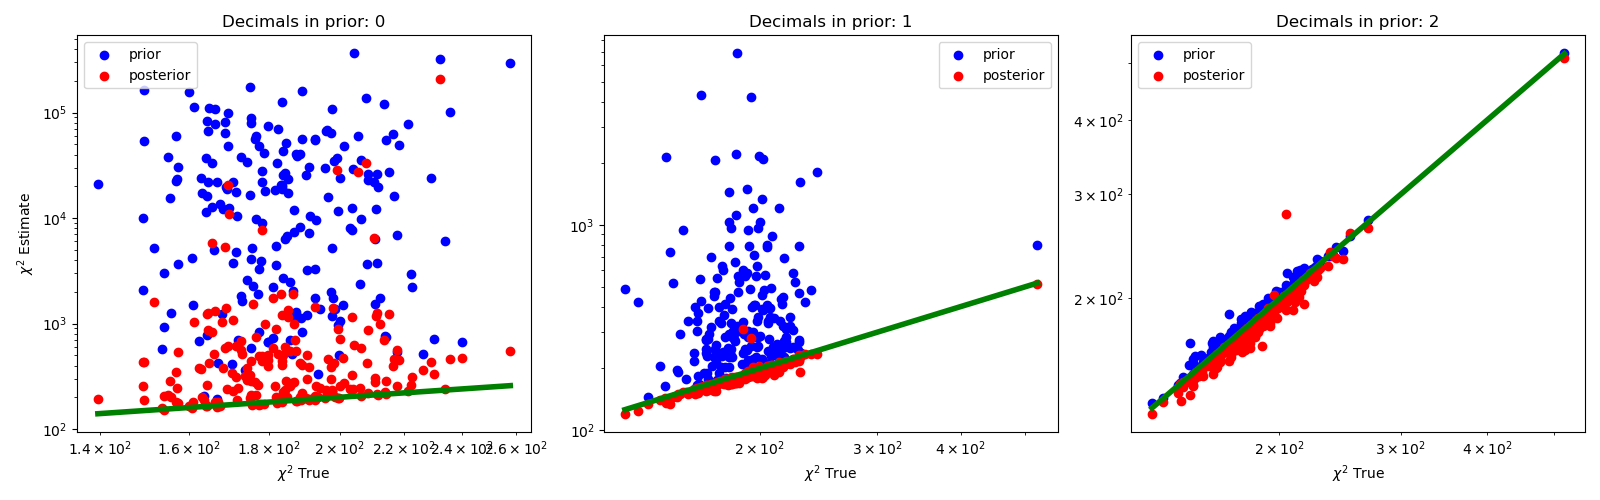

In [ ]:
from matplotlib.ticker import ScalarFormatter
# from matplotlib.ticker import MaxNLocator
decimals = 0
fig, (ax1,ax2, ax3) = subplots(1,3, figsize=(16,5))

for ax in [ax1,ax2,ax3]:
    ax.scatter(chi2_true[decimals,:], chi2_prior[decimals,:], color='b', label='prior')
    ax.scatter(chi2_true[decimals,:], chi2_posterior[decimals,:], color='r', label='posterior')
    ax.plot(np.sort(chi2_true[decimals,:]), np.sort(chi2_true[decimals,:]), color='g', lw=4)
    ax.set_xlabel(r'$\chi^2$ True')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    # ax.set_xticks(ax.get_xticks(), rotation = 45)
    # ax.set_xlim((min(chi2_true[decimals,:])-10, max(chi2_true[decimals,:])+10))
    # ax.set_adjustable("datalim")
    # ax.tick_params(axis='both', which='major', labelsize=5)
    # ax.xaxis.set_scientific(False)
    # ax.xaxis.set_major_formatter(ScalarFormatter())
    # ax.ticklabel_format(axis='x', style='plain', scilimits=(-2,10))
    # ax.xaxis.set_major_locator(MaxNLocator(nbins=1))
    # ax.get_xaxis().set_major_formatter(
    #     FuncFormatter(lambda x, p: format(int(x))))

    ax.set_title(f'Decimals in prior: {decimals}')

    decimals +=1


ax1.set_ylabel(r'$\chi^2$ Estimate')
fig.tight_layout()
# ax2.plot(chi2_prior[decimals,:]-chi2_true[decimals,:], '.', color='b', label='prior')       #chi2_true[decimals,:], 
# ax2.plot(chi2_posterior[decimals,:]-chi2_true[decimals,:], '.', color='r', label='posterior')       #chi2_true[decimals,:], 
# # ax2.set_xlabel(r'$\chi^2$ True')
# ax2.set_xlabel('sample')
# ax2.set_ylabel(r'$\chi^2_{est} - \chi^2_{true}$')
# ax2.legend()


In [ ]:
(50*10*30*10)*200*8/1e9

0.01831563888873418

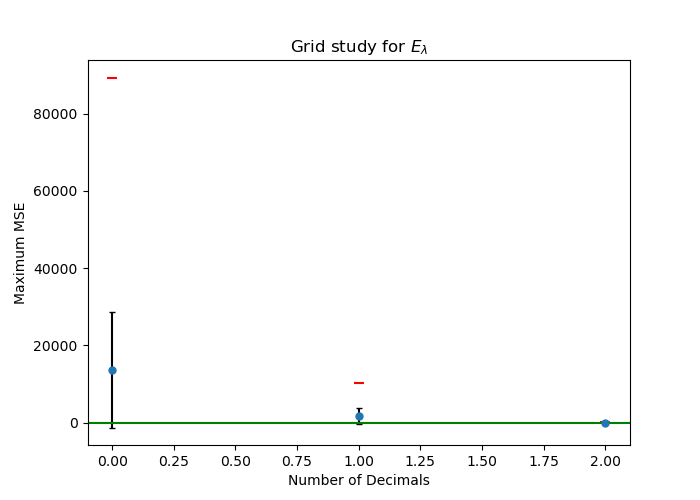

In [ ]:
figure(figsize=(7,5))
errorbar(range(decimals), np.mean(MSE_prior, axis=1), yerr= np.std(MSE_prior, axis=1), fmt='.', ms = 10,capsize=2, ecolor='k')
scatter(range(decimals), np.max(MSE_prior, axis=1), marker='_', color='r', s=50)
xlabel('Number of Decimals')
ylabel('Maximum MSE')
title(r'Grid study for $E_{\lambda}$')
# title(r'Grid study for $G_{tot}$')
# ylim([-0.5,100])
# yscale('log')
axhline(y=0, color='g')

# figure()
# plot(df_prior.E, df_prior.theo_trans)
# plot(exp.energy_domain, posterior.theo_trans, 'r')

In [ ]:
import scipy.stats as sts

Gnx_avg = np.mean(Gnx_s)
Gtot_avg = Gnx_avg + average_parameters['Gg']['3.0']
max_Gtot = sts.chi2.ppf(0.99, 1, loc=0, scale=Gnx_avg)/1 + average_parameters['Gg']['3.0']
min_Gtot = average_parameters['Gg']['3.0']
decimals_Gtot = 1
print(max_Gtot)
print(min_Gtot)

max_Elam = max(energy_grid) + Gtot_avg
min_Elam = min(energy_grid) - Gtot_avg
decimals_Elam = 3


Elam_features = np.arange(min_Elam, max_Elam, 1e0)
print(len(Elam_features))

/Users/noahwalton/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/noahwalton/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
64.0


ValueError: arange: cannot compute length

In [ ]:
1e-2

0.01